# Five qubit error correcting code

This notebook explains our Qiskit implementation of the five qubit error correcting code with a random Pauli error channel.

Authors: Arthur Diep-Nguyen, Amanda Curtis

**Outline**
1. Basic explanation of the five qubit error correcting code
2. State preparation
3. Random Pauli error
4. Measuring syndromes
5. Applying recovery operations
6. Simulating the entire circuit with various error probabilities
7. References

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile

import matplotlib.pyplot as plt
import numpy as np
import five_qubit_ecc

## The five qubit error correcting code

As discussed in Section 10.5.6 of *Quantum Computation and Quantum Information* by Nielsen and Chuang (hereby referred as N&C), the five qubit error correcting code is the smallest size quantum code encoding a single logical qubit that can detect and correct any error on any single physical qubit in the encoded state.

The five qubit code is an example of a stabilizer code, which is a class of quantum codes that can be viewed as analgous to classical linear codes (N&C pg. 453). The naming comes from the use of the group theoretic notion of stabilizers. The idea behind such codes is that "many quantum states can be more easily described by working with the operators that stabilize them than by working explicitly with the state itself" (N&C pg 454). Two reasons for this include the fact that many quantum codes can be described in a more compact way using stabilizer formalism than in thier vector state forms, and (perhaps more importantly) this formalism easily describes errors on qubits and operations like the Hadamard and controlled-NOT gates.

Stabilizer codes can be described with the naming convention $[[n,k,d]]$, where $n$ gives the number of physical qubuts used in the system, $k$ is the number of logical qubits being encoded, and $d$ is the code's distance. It is reasonable and useful to think of this as a vector space $V_S$ which is stabilized by a subgroup $S$ of $G_n$ - where this subgroup has $n-k$ independent generators. This subgroup is called the stabilizer, in-line with its group-theoretic name.

As a $[[5,1,3]]$ stabilizer code, the five qubit ECC encodes a single logical qubit with 5 physical qubits, and has a stabilizer generated by the 4 generators given below.
- $g_1 = XZZXI$
- $g_2 = IXZZX$
- $g_3 = XIXZZ$
- $g_4 = ZXIXZ$

We also have the following logical operators.
- $Z_L = ZZZZZ$
- $X_L = XXXXX$

As discussed in Section 10.5.5 of N&C, the logical basis state $|x_L\rangle$ is stabilized by

$$
\langle g_1, g_2, g_3, g_4, (-1)^x Z_L \rangle.
$$

The five qubit ECC has the following encoded logical states, which we prepare in the first section of this notebook.
$$
\begin{align*}
|0_L\rangle &=
\frac{1}{4} [
|00000\rangle + |10010\rangle + |01001\rangle + |10100\rangle \\
& \quad + |01010\rangle - |11011\rangle - |00110\rangle - |11000\rangle \\
& \quad - |11101\rangle - |00011\rangle - |11110\rangle - |01111\rangle \\
& \quad - |10001\rangle - |01100\rangle - |10111\rangle + |00101\rangle
] \\
|1_L\rangle &=
\frac{1}{4} [
|11111\rangle + |01101\rangle + |10110\rangle + |01011\rangle \\
& \quad + |10101\rangle - |00100\rangle - |11001\rangle - |00111\rangle \\
& \quad - |00010\rangle - |11100\rangle - |00001\rangle - |10000\rangle \\
& \quad- |01110\rangle - |10011\rangle - |01000\rangle + |11010\rangle
] \\
\end{align*}
$$

Our implementation does the following.
1. Given a boolean $x \in \mathbb{F}_2$, first prepare the logical state $|x_L\rangle$.
2. Apply random Pauli errors to $|x_L \rangle$.
3. Measure the generators $g_1, g_2, g_3, g_4$ to acquire a syndrome $(s_1, s_2, s_3, s_4)$.
4. Apply recovery operations depending on the syndrome.
5. Measure the logical state.

In the ideal situation where there are either zero errors or the error is corrected, measuring $|x_L\rangle$ should yield a component of $|x \rangle$, i.e. if the measurement is 10010, then we know $x=0$.

Of course, we may not be in the ideal situation. 
Although the five qubit ECC can correct arbitrary 1-qubit errors, if more than one qubit experiences too much noise, then the output may be measured to a code word that is not a component of the original logical state.
Later, we will simulate the five qubit ECC with varying error probabilities to see how the probability of a correct measurement changes.

## State preparation

To prepare the boolean $x \in \mathbb{F}_2$ into the logical state $|x_L\rangle$, we wrote a Qiskit function `prepare_state()` that implements a quantum circuit that prepares the state.

In [2]:
# Display the source code
five_qubit_ecc.prepare_state??

Signature: five_qubit_ecc.prepare_state(x: bool) -> qiskit.circuit.quantumcircuit.QuantumCircuit
Source:   
def prepare_state(x: bool) -> QuantumCircuit:
    """Returns a quantum circuit that prepares the logical state for the
    five-qubit error correcting code.

    Parameters
    ----------
    x : bool
        Boolean that will be prepared into a logical state

    Returns
    -------
    QuantumCircuit
        Quantum circuit that prepares the logical state |x_L>
        corresponding to the boolean `x`
    """
    qr = QuantumRegister(5, name="x")

    qc = QuantumCircuit(qr, name="state preparation")

    if x == True:
        qc.x(4)

    qc.h(0)
    qc.s(0)

    qc.cz(0,1)
    qc.cz(0,3)
    qc.cy(0,4)

    qc.h(1)

    qc.cz(1,2)
    qc.cz(1,3)
    qc.cx(1,4)

    qc.h(2)

    qc.cz(2,0)
    qc.cz(2,1)
    qc.cx(2,4)

    qc.h(3)
    qc.s(3)

    qc.cz(3,0)
    qc.cz(3,2)
    qc.cy(3,4)

    return qc
File:      ~/five-qubit-ecc/five_qubit_ecc.py
Type:      function

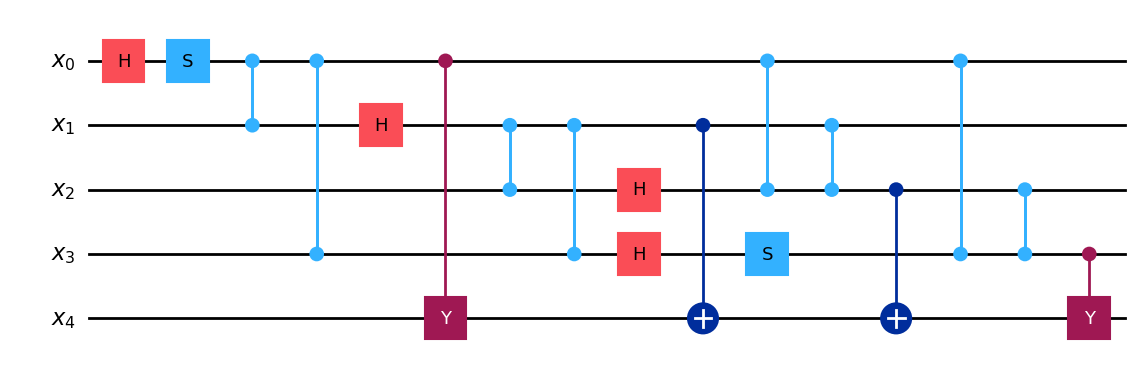

In [3]:
# Draw the circuit
five_qubit_ecc.prepare_state(False).draw("mpl")

Given a boolean $x\in{\mathbb{F}}_2$, described interms of the computational basis, this circuit reliably takes $x$ and perpares the logical basis state $|x_L\rangle$ from it, utilizing a set of unitary operations. Our circuit utilizes Hadamard gates, S-gates, controlled-Z gates, controlled Y-gatess, and controlled-NOT gates. 

## Applying random Pauli errors to the logical state

Let's say I wanted to send the single qubit $|x\rangle$ to my friend, but any qubits that I send get wired through a channel that has some probability $p$ of erroneously applying a Pauli $X$ gate, probability $p$ of erroneously applying a Pauli $Y$ gate, probability $p$ of erroneously applying a Pauli $Z$ gate, and a probability $1-3p$ of not applying any errors. 
(Assume that if I'm sending multiple qubits, the random Pauli errors are applied independently.)
Instead of simply sending $|x\rangle$, I'll first encode to the logical state $|x_L\rangle$ as above, then send $|x_L\rangle$ to my friend through the random Pauli error channel.
Although errors may be applied to $|x_L\rangle$ when it travels through the error channel, the use of the five qubit ECC gives my friend some hope of decoding the logical qubit he receives to the correct state.

We wrote a Qiskit function `error_channel()` that takes a parameter `p` and returns a quantum circuit that randomly and independently applies a Pauli error to each physical qubit, with probability $p$ for each qubit.

In [4]:
# Display the source code
five_qubit_ecc.error_channel??

Signature:
five_qubit_ecc.error_channel(
    p: float,
    nqubits: int = 5,
    seed: int | None = None,
) -> qiskit.circuit.quantumcircuit.QuantumCircuit
Source:   
def error_channel(p: float,
                    nqubits: int = 5,
                    seed: int | None = None) -> QuantumCircuit:
    """Returns a quantum circuit implementing a random Pauli error
    channel.

    Parameters
    ----------
    p : float
        Error probability for each physical qubit
    nqubits : int
        Number of physical qubits
    seed : int | None
        Random seed used for PRNG

    Returns
    -------
    QuantumCircuit
    """
    # Quantum register for physical qubits
    qr = QuantumRegister(nqubits, name="x")

    qc = QuantumCircuit(qr, name="error channel")

    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng = np.random.default_rng(seed)

    # For each physical qubit, randomly and independently apply each
    # Pauli gate with probability p, so 

Feel free to run the following cell a few times, modifying the parameter `p` as you wish.
Each time the cell is run, a new circuit is generated, possibly with different Pauli gates.

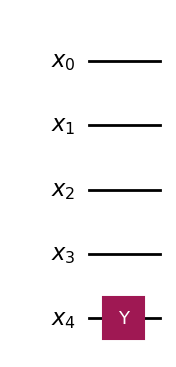

In [5]:
# Make sure that p is less than 1/3
p = 0.1

# Draw the circuit
five_qubit_ecc.error_channel(p, 5).draw("mpl")

## Measuring syndromes

Now that my friend has received the logical state $|x_L\rangle$, he will want to check if there are any errors.
By measuring the generators $(g_1, g_2, g_3, g_4)$ to the classical register $(s_1, s_2, s_3, s_4)$, the circuit can detect 1-qubit errors.

The procedure for constructing the circuits for measuring the generators is described in Section 10.5.8 of N&C, and examples are given in Figures 10.13, 10.14, and 10.15.
We implemented a Qiskit function `measure_syndromes()` that follows this procedure to generate such a circuit.

In [6]:
# Display the source code
five_qubit_ecc.measure_syndromes??

Signature: five_qubit_ecc.measure_syndromes() -> qiskit.circuit.quantumcircuit.QuantumCircuit
Source:   
def measure_syndromes() -> QuantumCircuit:
    """Returns the quantum circuit for measuring syndromes of the
    five-qubit error correcting code.
    """
    logical_state = QuantumRegister(5, name="x")

    # Quantum register for checking generators of the stabilizer
    checks = AncillaRegister(4, name="checks")

    # Classical register for measuring syndromes
    syndromes = ClassicalRegister(4, name="s")

    qc = QuantumCircuit(logical_state,
                        checks,
                        syndromes,
                        name="syndrome measurement")

    # Generators for the stabilizer are
    # XZZXI, IXZZX, XIXZZ, ZXIXZ

    # Measure the stabilizer generators, as in Figure 10.13 of N&C

    # XZZXI
    qc.h(checks[0])
    qc.cx(checks[0], logical_state[0])
    qc.cz(checks[0], logical_state[1])
    qc.cz(checks[0], logical_state[2])
    qc.cx(checks[0], logical_

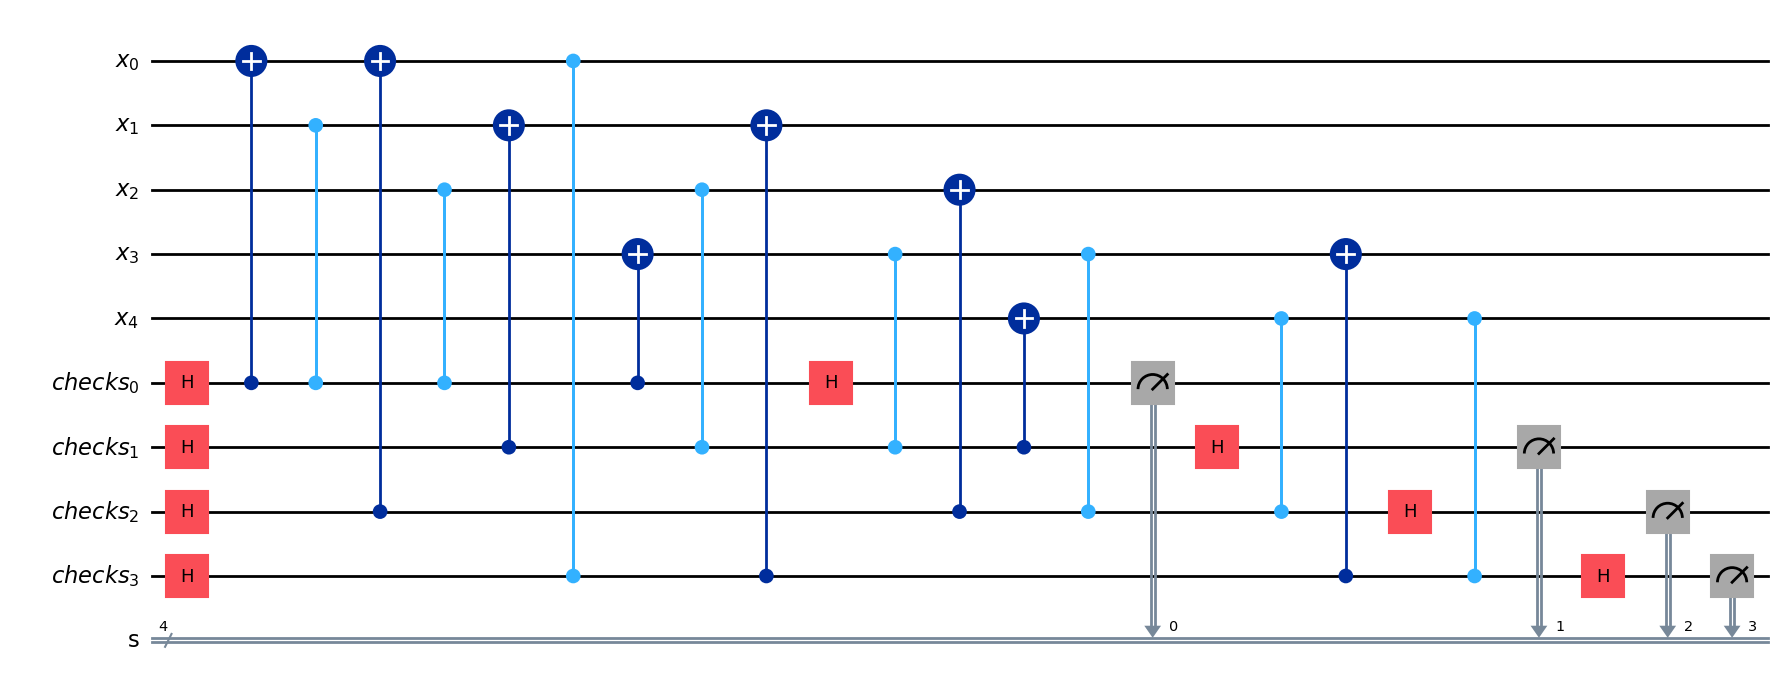

In [7]:
# Draw the circuit
five_qubit_ecc.measure_syndromes().draw("mpl")

## Applying recovery operations

Now that we have measured the generators $(g_1, g_2, g_3, g_4)$ and acquired the error syndrome $(s_1,s_2,s_3,s_4) \in \mathbb{F}_2^4$, we should be able to interpret the syndrome: The syndrome should indicate the type of error, and thus the required recovery operation to undo the error.

As discussed in Section 10.5.5 of N&C, if two errors $E_j$ and $E_{j'}$ have the same syndrome, then applying the recovery operation $E_j^\dagger$ not only corrects $E_j$, but also $E_{j'}$.
Thus, it suffices to find one error for each possible syndrome, and use the inverse of that error as the recovery operation.

By applying 1-qubit Pauli gates to each of the 5 physical qubits encoding the logical state, we may experimentally determine errors leading to each syndrome, and thus the fix to apply.
The results are summarized in the table below.

| Integer | $s_0 s_1 s_2 s_3$ | Fix           |
| ------- | ----------------- | ------------- |
| 0       | 0000              | $\varnothing$ |
| 1       | 1000              | $X_0$         |
| 2       | 0100              | $Z_2$         |
| 3       | 1100              | $X_4$         |
| 4       | 0010              | $Z_4$         |
| 5       | 1010              | $Z_1$         |
| 6       | 0110              | $X_3$         |
| 7       | 1110              | $Y_4$         |
| 8       | 0001              | $X_1$         |
| 9       | 1001              | $Z_3$         |
| 10      | 0101              | $Z_0$         |
| 11      | 1101              | $Y_0$         |
| 12      | 0011              | $X_2$         |
| 13      | 1011              | $Y_1$         |
| 14      | 0111              | $Y_2$         |
| 15      | 1111              | $Y_3$         |

We implemented a Qiskit function `error_correction()` to create a quantum circuit that uses a switch-case to apply the required fix, depending on the syndrome.

In [8]:
# Display the source code
five_qubit_ecc.error_correction??

Signature: five_qubit_ecc.error_correction() -> qiskit.circuit.quantumcircuit.QuantumCircuit
Source:   
def error_correction() -> QuantumCircuit:
    """Returns the quantum circuit that applies recovery operations
    based on the measured syndromes.
    """
    logical_state = QuantumRegister(5, name="x")

    # Classical register for measured syndromes
    syndromes = ClassicalRegister(4, name="s")

    qc = QuantumCircuit(logical_state,
                        syndromes,
                        name="recovery operations")

    with qc.switch(syndromes) as case:
        # case(0) needs no recovery operation
        with case(1):
            qc.x(0)
        with case(2):
            qc.z(2)
        with case(3):
            qc.x(4)
        with case(4):
            qc.z(4)
        with case(5):
            qc.z(1)
        with case(6):
            qc.x(3)
        with case(7):
            qc.y(4)
        with case(8):
            qc.x(1)
        with case(9):
            qc.z(3)
     

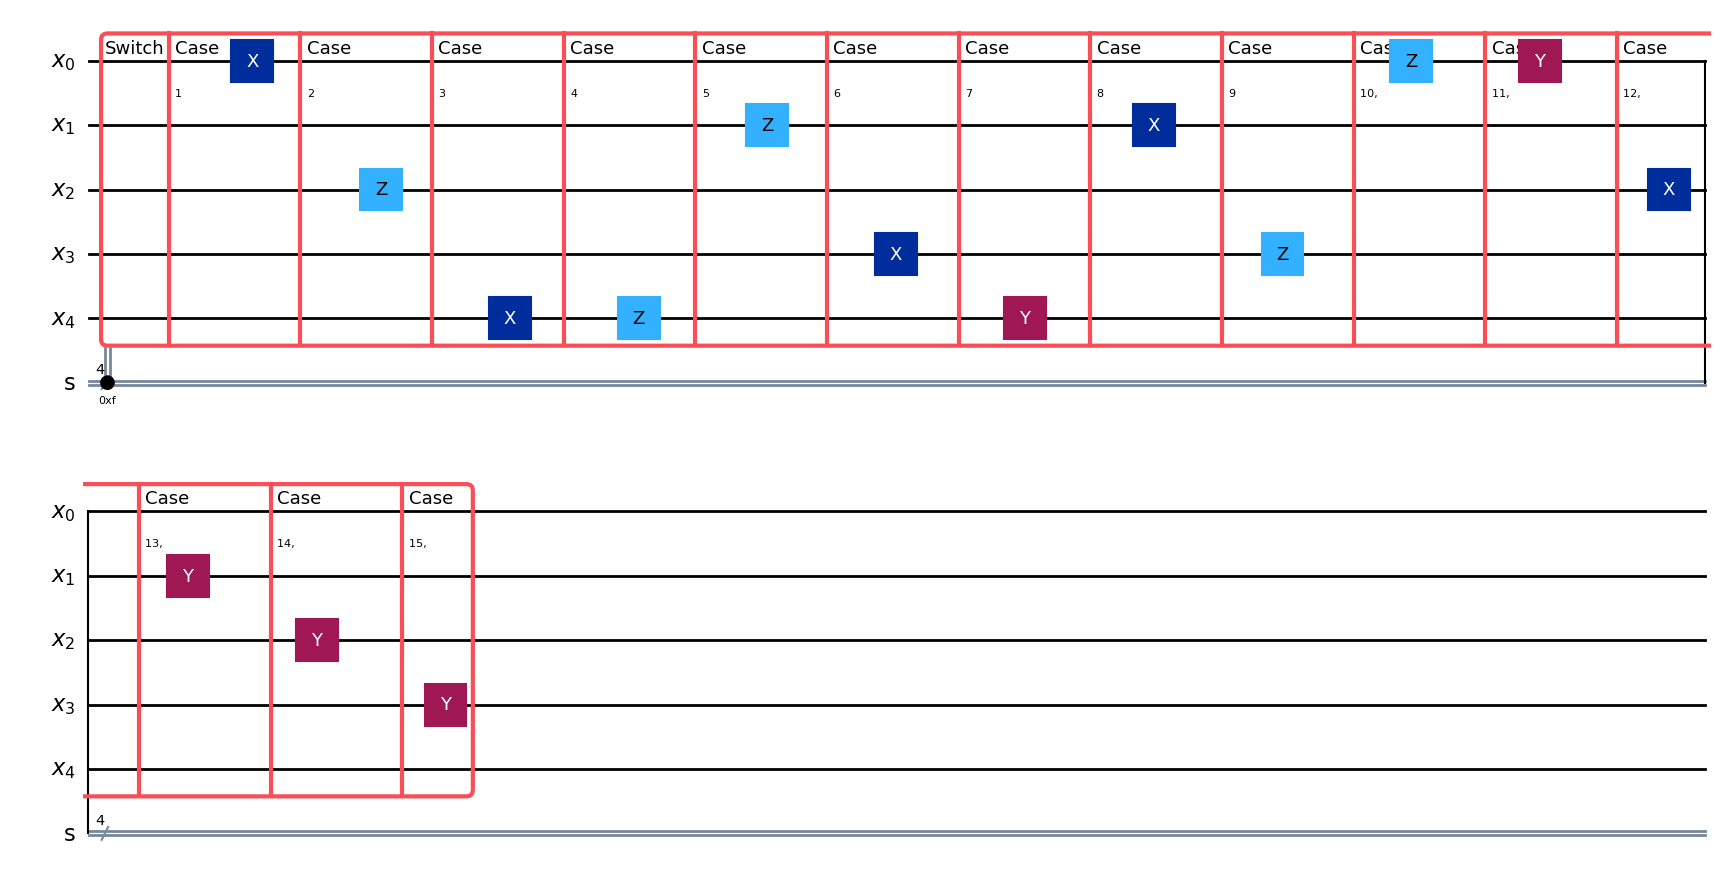

In [9]:
# Draw the circuit
five_qubit_ecc.error_correction().draw("mpl")

The circuit above shows the corrective gate (and quibit to which it is) applied in the case of of an error. The number corresponds to the errors 1-15 listed above.  

## Simulating the circuit

We now want to simulate our circuit for the five qubit error correcting code. 
In particular, we want to visualize the relationship between the error probability $p$ and the probability of successfully measuring a component of the logical state $|x_L\rangle$.

First, let us visualize the circuit itself.
Running the cell below will generate a circuit with random Pauli errors. 
Each time the cell is run, a new circuit will be generated, with possibly new Pauli errors, but the errors will be contained in the `error channel` gate, so cannot be seen in the drawing below.

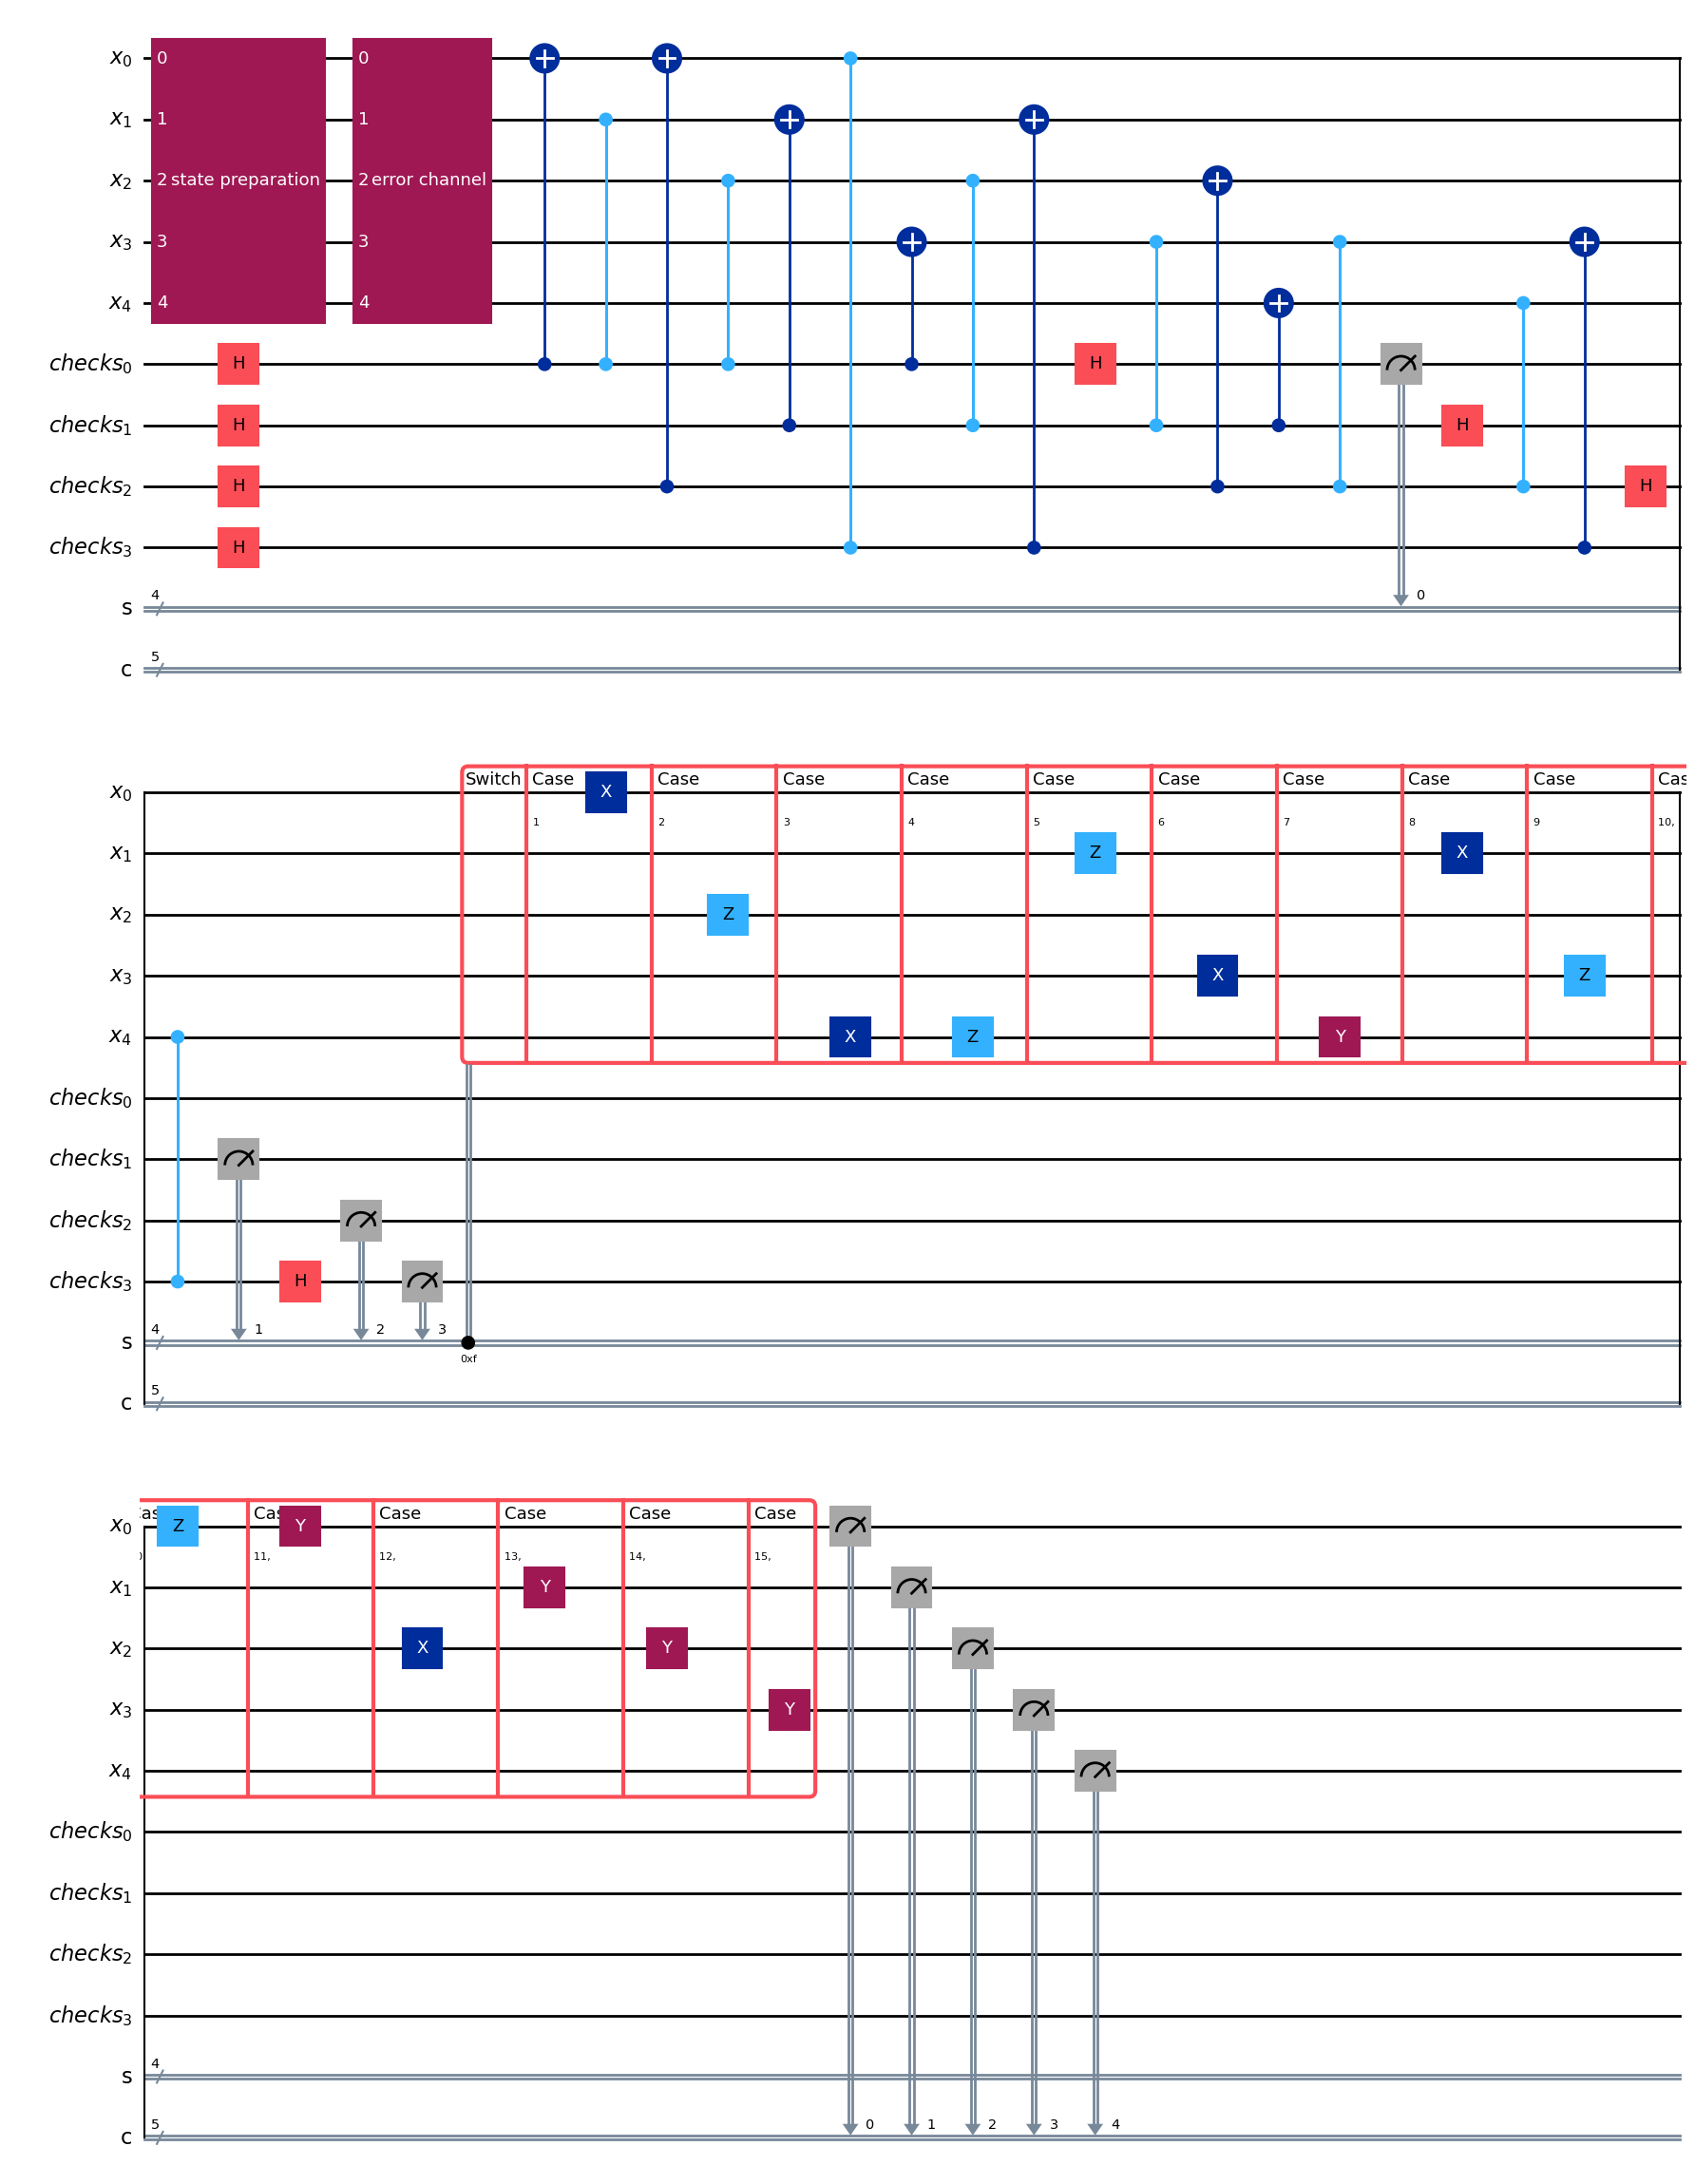

In [10]:
# Parameters for the main circuit
x = False
p = 0.05

# Draw the main circuit
five_qubit_ecc.main_circuit(x,p).draw("mpl")

Consider the following probabilities.
- The probability that all five physical qubits of the logical state acquire no errors when going through the random Pauli error channel is $(1-3p)^5$.
- The probability that one or fewer physical qubits acquires an error is $(1-3p)^5 + 5 (1-3p)^4 (3p)$.

We know that the five qubit error correcting code can correct arbitrary 1-qubit errors, but cannot correct larger errors.
Thus, the probability that the logical state acquires a correctable error (including no error) is $(1-3p)^5 + 5 (1-3p)^4 (3p)$.
Let us plot this below.

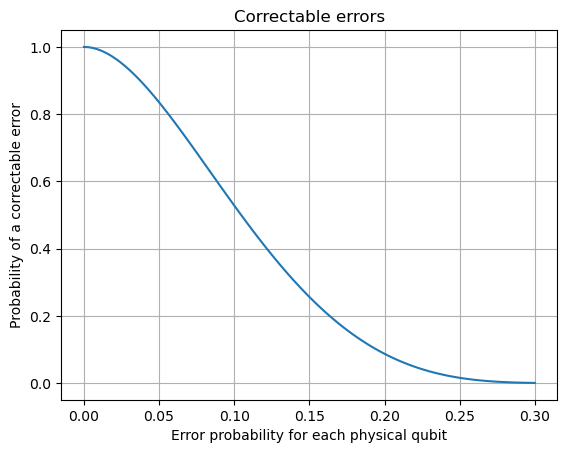

In [11]:
p = np.linspace(0,0.3,100)
prob = np.power(1-3*p, 5) + 15*p*np.power(1-3*p,4)
plt.plot(p, prob)
plt.xlabel("Error probability for each physical qubit")
plt.ylabel("Probability of a correctable error")
plt.title("Correctable errors")
plt.grid(True)
plt.show()

When $p \approx 0$, the errors are very likely to be correctable, so we expect to measure a correct component of the logical state $|x_L\rangle$.
However, as $p \to \frac{1}{3}$ from the left, the probability of a correctable error tends to zero, so we expect to measure a correct component about 50% of the time.

Now we will simulate the circuit many times. Feel free to run the following cells a few times if you'd like to redo the simulations.

In [12]:
# Parameters for simulations
x = False
probs = [0.025 * x for x in range(1,13)]    # List of error probabilities
num_sims = 250                              # Number of simulations for each element of `probs`

# Simulation results as a dictionary
# On my device, it takes 80 s to do 1000 simulations
# With the above parameters, the 3000 simulations should take about 4 min
results = five_qubit_ecc.simulation_results(x=x,probs=probs,num_sims=num_sims)

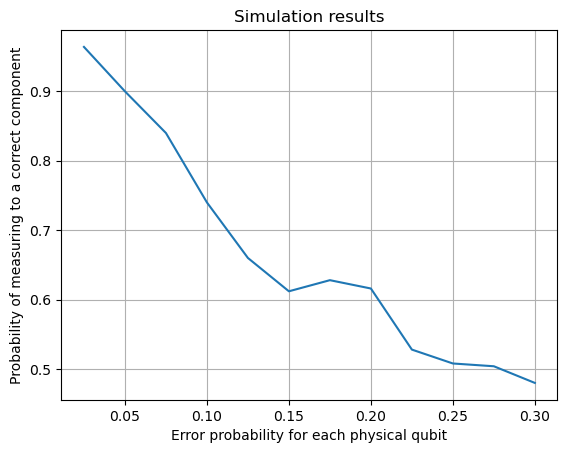

In [13]:
plt.plot(*zip(*sorted(results.items())))
plt.xlabel("Error probability for each physical qubit")
plt.ylabel("Probability of measuring to a correct component")
plt.title("Simulation results")
plt.grid(True)
plt.show()

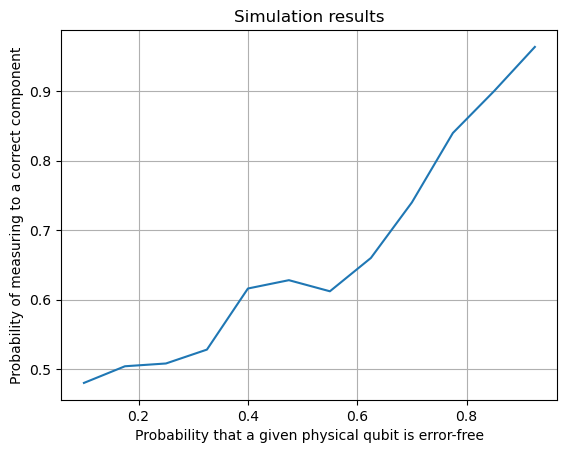

In [15]:
# New dictionary where each key is the probability that a physical qubit is error-free
results_alt = dict()
for key in results:
    results_alt.update({1-3*key: results.get(key)})

plt.plot(*zip(*sorted(results_alt.items())))
plt.xlabel("Probability that a given physical qubit is error-free")
plt.ylabel("Probability of measuring to a correct component")
plt.title("Simulation results")
plt.grid(True)
plt.show()

Let's simulate the circuit again, this time for smaller values of $p$.

In [16]:
# Parameters for simulations
x = True
probs = [0.005 * x for x in range(1,21)]    # List of error probabilities
num_sims = 250                              # Number of simulations for each element of `probs`

# Simulation results as a dictionary
# On my device, it takes 80 s to do 1000 simulations
# With the above parameters, the 5000 simulations should take about 6 min 40 s
results_small_p = five_qubit_ecc.simulation_results(x=x,probs=probs,num_sims=num_sims)

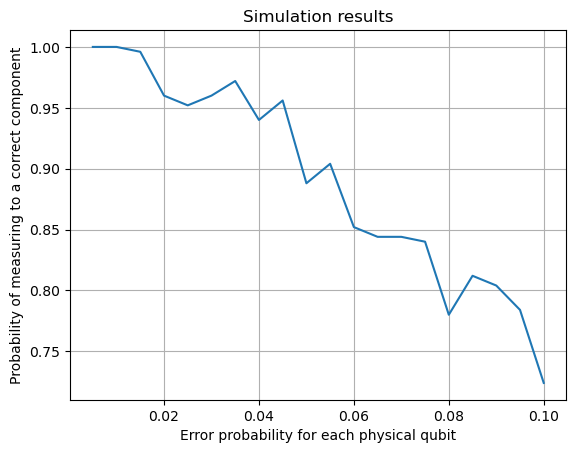

In [17]:
plt.plot(*zip(*sorted(results_small_p.items())))
plt.xlabel("Error probability for each physical qubit")
plt.ylabel("Probability of measuring to a correct component")
plt.title("Simulation results")
plt.grid(True)
plt.show()

Let us compare some of these experimental results with the known probability of a correctable error.

First, let's consider a very low error, say $p=0.04$.
- In our experiment, when $p = 0.04$, the probability of measuring to a correct component of $|x_L\rangle$ is a bit less than $0.95$.
- Plugging $p=0.04$ into $(1-3p)^5 + 5 (1-3p)^4 (3p)$, we find that the probability of acquiring a correctable error is about $0.8875$.
- If we don't get a correctable error, and we assume that a non-correctable error has a 50% chance of being measured to a correct component, then we get $0.8875 + 0.1124*0.5 \approx 0.9438$, which is similar to what we see in our experiment.

Next, let's consider a more sizeable error, say $p=0.08$.
- In our experiment, the probability of a correct measurement drops to below $0.80$. It looks like $0.78$.
- Plugging $p=0.08$ into $(1-3p)^5 + 5 (1-3p)^4 (3p)$, we find that the probability of acquiring a correctable error is about $0.6539$.
- Again, assuming that a noncorrectable error has a 50% chance of a correct measurement, we get $0.6539 + 0.3461 * 0.5 \approx 0.8369$, which is somewhat greater than our experimental result.

## References

- *Quantum Computation and Quantum Information* by Nielsen and Chuang